## Introduction
In this model we will train 3 different models to predict whether a police officer will attend an accident. The notebook is structured as follows:
1. Run data preparation. This manipulates the train data to have features engineered in 01 EDA.ipynb
2. Split data into train and test sets
3. Define functions used for model training. model_udf runs Grid Search CV on the model you input with parameters inputted. Plot cross val, plots the ROC AUC at different parameters for the train and test set. Plot_auc plots the ROC curve 
4. Train a KNN model using longitude and latitude and a few other top features. The parameter tuned is number of neighbours.
5. Train an XGB model tuning the learning rate
6. Train a logistic regression model tuning L2 regularisation
7. Run data prep on the test set and make predictions using the chosen model


## Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

import data_prep2 as dp

pd.set_option('display.max_columns', 500)

In [2]:
# import sklearn
# import xgboost
# print("sklearn=="+sklearn.__version__)
# print("xgboost=="+xgboost.__version__)

In [3]:
df = dp.data_preparation('train_data.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Police_Force
(138660, 32)
Accident_Severity
(138660, 32)
Day_of_Week
(138660, 32)
Local_Authority_(District)
(138660, 32)
Local_Authority_(Highway)
(138660, 32)
1st_Road_Class
(138660, 32)
Road_Type
(138660, 32)
Junction_Detail
(138660, 32)
Junction_Control
(138660, 32)
2nd_Road_Class
(138660, 32)
Light_Conditions
(138660, 32)
Weather
(138660, 32)
Road_Surface
(138660, 32)
Special_Conditions_at_Site
(138660, 32)
Carriageway_Hazards
(138660, 32)
Urban_Rural
(138660, 32)
Police_Officer_Attend
(138660, 32)


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
# double check the target has the ratio as expected
df['target'].value_counts()

1    113358
0     25302
Name: target, dtype: int64

In [5]:
# load in the feature dictionary. These are features to be used by different models
feature_dict = dp.load_obj('feature_dict')

## Split data into train and test

In [6]:
X = df
y = df['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Define functions for model training

In [8]:
def model_udf(estimator_name,estimator,parameters,X,y):
    '''
    Return a fitted model on the X and y
    estimator name : string for the name of the estimator step in the pipeline
    estimator : sklearn estimator e.g. KNeighborsClassifier
    parameters : dictionary, parameter grid for Grid Search
    '''
#     steps = [('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
#              ('scaler',StandardScaler()),
#              ('onehot', OneHotEncoder(handle_unknown='ignore')),
#             (estimator_name, estimator)]

#     pipe = Pipeline(steps)

    numeric_features = list(X._get_numeric_data().columns)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = list(set(X.columns) - set(X._get_numeric_data().columns))
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          (estimator_name, estimator)])


    parameters = parameters

    clf = GridSearchCV(pipe, param_grid=parameters,return_train_score=True,scoring='roc_auc',verbose=3,cv=3,refit=True)

    clf.fit(X,y)
    
    return clf

In [39]:
def plot_cross_val(clf,col,log=False):
    '''
    This function plots the score for a GridSearchCV object at different parameter values (col) for train and test set.
    
    Parameters:
    clf: sklearn.model_selection._search.GridSearchCV. Trained GridSearchCV object
    col: column that contains the parameters trained
    log: boolean. whether to plot the parameters on log scale. Useful for regularisation on a log scale
    
    Returns:
    matplotlib plot
    
    '''
    
    fig, ax = plt.subplots()
    cv_results = pd.DataFrame(clf.cv_results_)[[col,'params','mean_score_time','mean_train_score','mean_test_score']]    
    ax.plot(cv_results[col],cv_results['mean_test_score'],label='mean_test_score')
    ax.plot(cv_results[col],cv_results['mean_train_score'],label='mean_train_score')
    ax.set_xlabel(col)
    ax.set_ylabel('score')
    ax.legend()
    if log == True:
        ax.set_xscale('log')
    return cv_results

In [10]:
def print_best_model(clf):
    '''
    Print the best models score and parameter from GridSearchCV
    '''
    print(f'The Grid Search best score is {clf.best_score_:0.1%} and the best parameters are {clf.best_params_}')


In [40]:
def get_best_model(clf):
    '''
    Get the model that was trained for the best estimator. Because the estimator is a pipeline, we need to extract the trained model to get coefficients etc
    '''
    return clf.best_estimator_.steps[1][1]

In [41]:
def plot_auc(model,features):
    '''
    Plot the ROC and get AUC for model using the X_test and y_test global variables
    '''
    
    from sklearn import metrics
    y_pred_proba = model.predict_proba(X_test[features])[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

## KNN
Train a KNN model, using features of longitude and latitude.
The logic here is that targets might be near each other

In [13]:

clf_knn = model_udf(
    'knn'
    ,KNeighborsClassifier()
    ,parameters = {'knn__n_neighbors':np.arange(10,70,10)},X=X_train[feature_dict['knn']]
        ,y=y_train
)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] knn__n_neighbors=10 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=10, score=(train=0.803, test=0.668), total=   1.4s
[CV] knn__n_neighbors=10 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  knn__n_neighbors=10, score=(train=0.806, test=0.665), total=   1.3s
[CV] knn__n_neighbors=10 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV]  knn__n_neighbors=10, score=(train=0.807, test=0.663), total=   1.3s
[CV] knn__n_neighbors=20 .............................................
[CV]  knn__n_neighbors=20, score=(train=0.766, test=0.691), total=   1.5s
[CV] knn__n_neighbors=20 .............................................
[CV]  knn__n_neighbors=20, score=(train=0.770, test=0.683), total=   1.5s
[CV] knn__n_neighbors=20 .............................................
[CV]  knn__n_neighbors=20, score=(train=0.770, test=0.684), total=   1.5s
[CV] knn__n_neighbors=30 .............................................
[CV]  knn__n_neighbors=30, score=(train=0.752, test=0.699), total=   1.8s
[CV] knn__n_neighbors=30 .............................................
[CV]  knn__n_neighbors=30, score=(train=0.756, test=0.692), total=   1.6s
[CV] knn__n_neighbors=30 .............................................
[CV]  knn__n_neighbors=30, score=(train=0.756, test=0.695), total=   1.6s
[CV] knn__n_neighbors=40 ...............................

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.2min finished


In [14]:
print_best_model(clf_knn)

The Grid Search best score is 70.5% and the best parameters are {'knn__n_neighbors': 60}


We can see that with fewer neighbours the model was overfitting the train set and underfitting the set. As we increased the model parameter it started to fit both equally

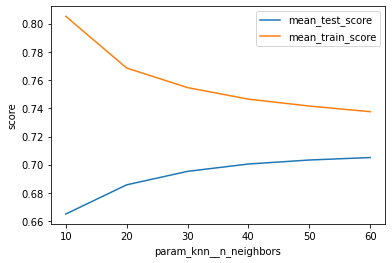

In [15]:
cv_results_knn = plot_cross_val(clf_knn,'param_knn__n_neighbors')

The AUC on test set is 0.7

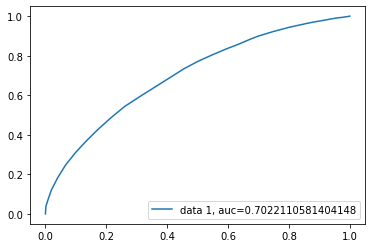

In [16]:
model_knn = clf_knn.best_estimator_

plot_auc(model_knn,feature_dict['knn'])

## XGBoost

Here we will train XGBoost tuning the learning rate

In [17]:

clf_xgb = model_udf(
    'xgb'
    ,XGBClassifier()
    ,parameters = {'xgb__eta':[0.05,0.1,0.3,0.5,0.7]},X=X_train[feature_dict['cleaned']]
        ,y=y_train
)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] xgb__eta=0.05 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... xgb__eta=0.05, score=(train=0.735, test=0.732), total=   2.9s
[CV] xgb__eta=0.05 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] ... xgb__eta=0.05, score=(train=0.739, test=0.722), total=   2.8s
[CV] xgb__eta=0.05 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] ... xgb__eta=0.05, score=(train=0.735, test=0.732), total=   2.7s
[CV] xgb__eta=0.1 ....................................................
[CV] .... xgb__eta=0.1, score=(train=0.739, test=0.732), total=   2.7s
[CV] xgb__eta=0.1 ....................................................
[CV] .... xgb__eta=0.1, score=(train=0.742, test=0.722), total=   2.7s
[CV] xgb__eta=0.1 ....................................................
[CV] .... xgb__eta=0.1, score=(train=0.739, test=0.731), total=   2.8s
[CV] xgb__eta=0.3 ....................................................
[CV] .... xgb__eta=0.3, score=(train=0.744, test=0.727), total=   2.7s
[CV] xgb__eta=0.3 ....................................................
[CV] .... xgb__eta=0.3, score=(train=0.747, test=0.719), total=   2.6s
[CV] xgb__eta=0.3 ....................................................
[CV] .... xgb__eta=0.3, score=(train=0.744, test=0.728), total=   2.7s
[CV] xgb__eta=0.5 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   43.0s finished


A smaller learning rate gave the best results

In [18]:
print_best_model(clf_xgb)

The Grid Search best score is 72.9% and the best parameters are {'xgb__eta': 0.05}


We can see with a larger learning rate that the model was overfitting hte train set and as we reduced the learning rate it fit both train and set more equally

,param_xgb__eta,params,mean_score_time,mean_train_score,mean_test_score
0,0.05,{'xgb__eta': 0.05},0.078942,0.736341,0.728758
1,0.1,{'xgb__eta': 0.1},0.080006,0.739752,0.728391
2,0.3,{'xgb__eta': 0.3},0.076922,0.744918,0.724761
3,0.5,{'xgb__eta': 0.5},0.076512,0.746965,0.722970
4,0.7,{'xgb__eta': 0.7},0.080641,0.748375,0.722069


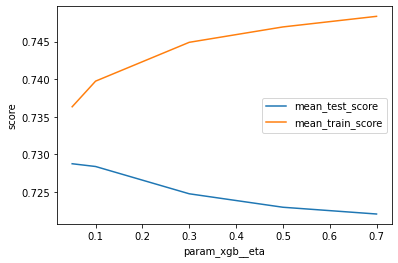

In [19]:
plot_cross_val(clf_xgb,'param_xgb__eta')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

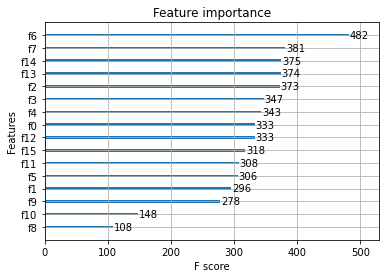

In [20]:
from xgboost import plot_importance
model_xgb = get_best_model(clf_xgb)
plot_importance(model_xgb)

In [21]:
list(enumerate(X_train[feature_dict['cleaned']].columns))

[(0, 'night_time'),
 (1, '15_mins_past_hour'),
 (2, 'weekday'),
 (3, 'number_of_casualties_more_than_2'),
 (4, 'number_of_vehicles_more_than_2'),
 (5, 'speed_limit_high'),
 (6, 'police_force_high'),
 (7, 'accident_severity_high'),
 (8, '1st_road_class_high'),
 (9, 'road_type_high'),
 (10, 'light_conditions_high'),
 (11, 'weather_high'),
 (12, 'location_northing_osgr_str1_high'),
 (13, 'police_force_low'),
 (14, 'road_type_low'),
 (15, 'NUTS_ID_low')]

The AUC is stronger than KNN with a score of 0.73

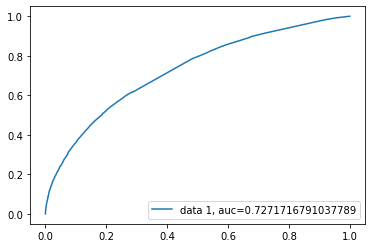

In [22]:
model_xgb = clf_xgb.best_estimator_

plot_auc(model_xgb,feature_dict['cleaned'])

## LogisticRegression
We will train a logistic regression binary classification model tuning l2 regularisation. L2 regularisation makes some coefficients close to zero to prevent ovefitting the train set.

In [23]:

clf_logreg = model_udf(
    'logreg'
    ,LogisticRegression(penalty='l2')
    ,parameters = {'logreg__C':[0.01,0.1,1,10,100,1000]},X=X_train[feature_dict['cleaned']]
        ,y=y_train
)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] logreg__C=0.01 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. logreg__C=0.01, score=(train=0.725, test=0.731), total=   0.3s
[CV] logreg__C=0.01 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .. logreg__C=0.01, score=(train=0.731, test=0.719), total=   0.3s
[CV] logreg__C=0.01 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] .. logreg__C=0.01, score=(train=0.726, test=0.730), total=   0.3s
[CV] logreg__C=0.1 ...................................................
[CV] ... logreg__C=0.1, score=(train=0.725, test=0.731), total=   0.3s
[CV] logreg__C=0.1 ...................................................
[CV] ... logreg__C=0.1, score=(train=0.731, test=0.719), total=   0.3s
[CV] logreg__C=0.1 ...................................................
[CV] ... logreg__C=0.1, score=(train=0.726, test=0.730), total=   0.3s
[CV] logreg__C=1 .....................................................
[CV] ..... logreg__C=1, score=(train=0.725, test=0.731), total=   0.3s
[CV] logreg__C=1 .....................................................
[CV] ..... logreg__C=1, score=(train=0.731, test=0.719), total=   0.3s
[CV] logreg__C=1 .....................................................
[CV] ..... logreg__C=1, score=(train=0.726, test=0.730), total=   0.3s
[CV] logreg__C=10 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.9s finished


In [24]:
print_best_model(clf_logreg)

The Grid Search best score is 72.7% and the best parameters are {'logreg__C': 10}


Changing regularisation did not make much difference to the scores

,param_logreg__C,params,mean_score_time,mean_train_score,mean_test_score
0,0.01,{'logreg__C': 0.01},0.035335,0.727387,0.726645
1,0.1,{'logreg__C': 0.1},0.034418,0.727352,0.726642
2,1,{'logreg__C': 1},0.033645,0.727348,0.726653
3,10,{'logreg__C': 10},0.034135,0.727349,0.726655
4,100,{'logreg__C': 100},0.034920,0.727348,0.726653
5,1000,{'logreg__C': 1000},0.038456,0.727349,0.726652


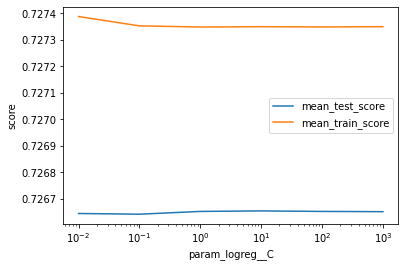

In [25]:
plot_cross_val(clf_logreg,'param_logreg__C',log=True)

## Plot the coefficients
We can see the model learnt patterns as expected i.e. high speed limit, more vehicles, higher accident severity and poor weather conditions increases likelihood

<AxesSubplot:xlabel='features'>

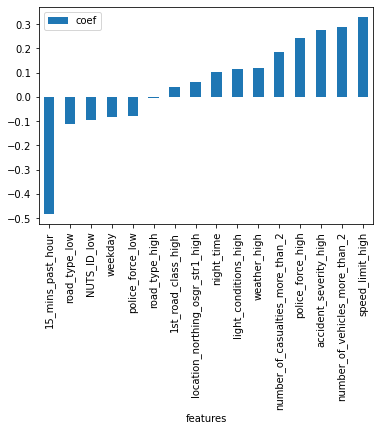

In [26]:
model_logreg = get_best_model(clf_logreg)

df_coef = pd.DataFrame(zip(X_train[feature_dict['cleaned']].columns, np.transpose(model_logreg.coef_)), columns=['features', 'coef']) 


df_coef['coef'] = df_coef['coef'].apply(lambda x: x[0])

df_coef = df_coef.sort_values(by='coef')

df_coef.set_index('features').plot.bar()

We have a score of 72.5 on the test set

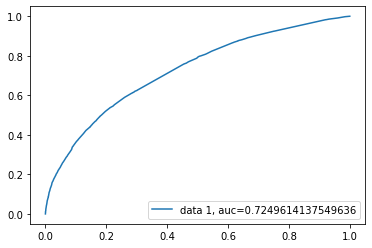

In [27]:
model_logreg = clf_logreg.best_estimator_

plot_auc(model_logreg,feature_dict['cleaned'])

# Make predictions on final test set

Prepare the test data

In [28]:
test_df = dp.data_preparation('test_data.csv')

Police_Force
(12303, 32)
Accident_Severity
(12303, 32)
Day_of_Week
(12303, 32)
Local_Authority_(District)
(12303, 32)
Local_Authority_(Highway)
(12303, 32)
1st_Road_Class
(12303, 32)
Road_Type
(12303, 32)
Junction_Detail
(12303, 32)
Junction_Control
(12303, 32)
2nd_Road_Class
(12303, 32)
Light_Conditions
(12303, 32)
Weather
(12303, 32)
Road_Surface
(12303, 32)
Special_Conditions_at_Site
(12303, 32)
Carriageway_Hazards
(12303, 32)
Urban_Rural
(12303, 32)
Police_Officer_Attend
(12303, 32)


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Make a probability prediction using the logreg model

In [30]:
pred = clf_logreg.predict_proba(test_df[feature_dict['cleaned']])[::,1]

The prediction probability mean is what we'd expect of 81%

In [31]:
pred.mean()

0.8136347088052418

Generate output

In [32]:
output = pd.DataFrame({'accident_index': test_df['accident_index'],'probability_to_attend':pred})

Create histogram of predictions. They are distributed around the 80% mark which is as expected as it's the total target rate on train

<AxesSubplot:>

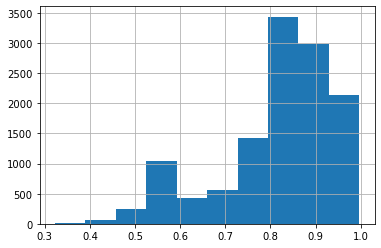

In [33]:
output['probability_to_attend'].hist()

Isolate IDs with high probability to see if the variables make sense. Picking out one highly score ID, we see that it is a dangerous accident with high severity and casualties/vehicles and poor lighting conditions

In [34]:
output[output['probability_to_attend']<0.99]['accident_index'].head()

0    201401BS70277
1    201401BS70278
2    201401BS70279
3    201401BS70280
4    201401BS70281
Name: accident_index, dtype: object

In [35]:
test_df[['accident_index']+feature_dict['cleaned']].query('accident_index=="201404CA14085"')

,accident_index,night_time,15_mins_past_hour,weekday,number_of_casualties_more_than_2,number_of_vehicles_more_than_2,speed_limit_high,police_force_high,accident_severity_high,1st_road_class_high,road_type_high,light_conditions_high,weather_high,location_northing_osgr_str1_high,police_force_low,road_type_low,NUTS_ID_low
2396,201404CA14085,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0


Save output as csv

In [36]:
output.to_csv('test_output.csv',index=False)

# Report

a. What was the approach taken and why (e.g. algorithms and tools)?  
My approach was to explore the data and see if i could engineer useful features. For example, i could use the minute value from the time column to see if target was higher by minute.
I also looked at whether certain locations had higher target rates. I created substrings of location variables, and visualised on a map to see if they match areas with higher rates of targets. I then binned categorical variables with similar target rates, to improve interpretability and reduce training time. 
I started with KNN using longitude and latitude as from my visualisation it showed that there were clusters of the target, so my hypothesis was targets occur near each other.

b. Approaches that you tried and did not work.   
KNN did not work well of the three models, this could be because location is not the main factor.

c. What were the main challenges?  
Finding variables which have give a strong signal for police officers attending.  
The variables being IDs was difficult at first but made easier when I got the lookup tables. The challenge from that was then joining to the data, as column names weren't consistent  
As there were so many variables, it was a challenge to find the most important factors and visualise in one go. I opted for finding low cardinality variables and visualising those


d. What insight did you gain from working with the data?  
The higher the speed limit, the more likely a police officer will attend  
Some police forces are more likely to attend accidents such as south wales and tayside. the met police is the most common police force  
The more severe an accident the more likely a police officer will attend  
Police Officers have a higher chance of attending a motorway/dual carriageway  
No lighting/night time has a higher target rate, perhaps because it's more dangerous  
Police officers are more likely to attend in wet/damp conditions vs dry  
Police officers are more likely to attend in a rural area  (possibly because speed is higher as these two variables correlate)


e. How useful is the model?  
The model is useful in driving insights to what scenarios police officers attend accidents. e.g. we can see it's more likely on high speed roads. We can understand how to reduce the burden on police by making high speed roads safer.

f. What might you do differently if you had more time/resource?  
I would reduce repeatability in my code (however there's a trade off that having functions/modules makes code difficult to follow), and add more commenting in my functions. Also reduce hardcoding as much as possible.    
Perhaps would not bin categories at such a high level, and have some categorical variables dummified instead so the model can understand some categories drive higher likelihood than others  
I could optimise more hyperparameters on the models with more time.  
I would add logging to my dataprep function so we can understand what's happening in the background

g. What other data sources you would have used to enhance your model.   
perhaps historic data on the locations to see how severe the area is. police might be more likely to attend if it historically has severe accidents
